<a href="https://colab.research.google.com/github/sergekamanzi/Fraud-Detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#adam and L2

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6447 - loss: 0.9776 - val_accuracy: 0.5951 - val_loss: 0.8599
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8252 - loss: 0.8488 - val_accuracy: 0.3737 - val_loss: 0.8365
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8369 - loss: 0.8095 - val_accuracy: 0.4844 - val_loss: 0.8028
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8655 - loss: 0.7654 - val_accuracy: 0.5535 - val_loss: 0.7653
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8736 - loss: 0.7250 - val_accuracy: 0.6547 - val_loss: 0.7195
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8826 - loss: 0.6855 - val_accuracy: 0.7597 - val_loss: 0.6682
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8903 - loss: 0.6442 - val_accuracy: 0.7597 - val_loss: 0.6277
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9040 - loss: 0.6042 - val_accuracy: 0.

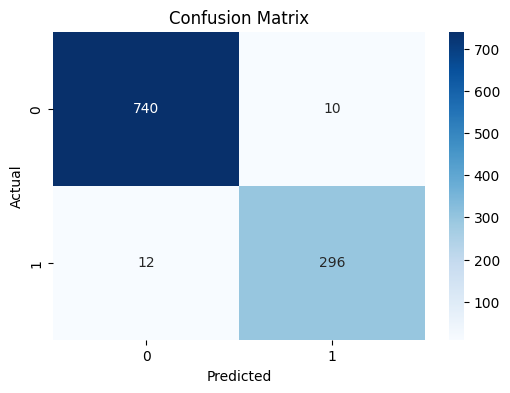

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

# Load Dataset
data = pd.read_csv('/content/frauds_dataset.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

# Feature Engineering
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

# Handle missing values
data.fillna(data.median(), inplace=True)

# Drop unnecessary columns
data.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}

# Custom Focal Loss Function
def focal_loss(alpha=0.75, gamma=3):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = alpha * K.pow((1 - p_t), gamma)
        return focal_term * bce
    return loss

# Define the Advanced Neural Network Model with L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.75, gamma=3), metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Adjust Classification Threshold Using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_pred_probs)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > best_threshold).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#RMSprop and L1

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7279 - loss: 14.9750 - val_accuracy: 0.3869 - val_loss: 13.5407
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8623 - loss: 13.0957 - val_accuracy: 0.3680 - val_loss: 12.1664
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8824 - loss: 11.5275 - val_accuracy: 0.3841 - val_loss: 10.6449
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8994 - loss: 9.8995 - val_accuracy: 0.3879 - val_loss: 9.1847
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9109 - loss: 8.4090 - val_accuracy: 0.6405 - val_loss: 7.6904
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9221 - loss: 7.0371 - val_accuracy: 0.6131 - val_loss: 6.5577
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9276 - loss: 5.8709 - val_accuracy: 0.6424 - val_loss: 5.5323
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9326 - loss: 4.8909 - val_accura

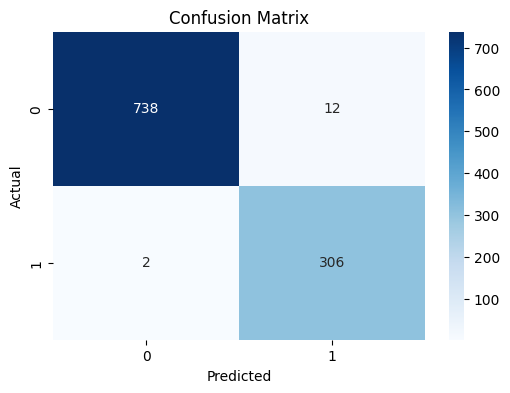

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

# Load Dataset
data = pd.read_csv('/content/frauds_dataset.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

# Feature Engineering
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

# Handle missing values
data.fillna(data.median(), inplace=True)

# Drop unnecessary columns
data.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}

# Define the Advanced Neural Network Model with L1 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l1(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l1(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#SDG and l1-l2

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5900 - loss: 9.0383 - val_accuracy: 0.6320 - val_loss: 8.1964
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7690 - loss: 8.4902 - val_accuracy: 0.3377 - val_loss: 8.2037
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8016 - loss: 8.2776 - val_accuracy: 0.3302 - val_loss: 8.2134
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8099 - loss: 8.1669 - val_accuracy: 0.3321 - val_loss: 8.2059
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8263 - loss: 8.0701 - val_accuracy: 0.3359 - val_loss: 8.1934
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8324 - loss: 7.9991 - val_accuracy: 0.3699 - val_loss: 8.1485
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8499 - loss: 7.9135 - val_accuracy: 0.5166 - val_loss: 8.1085
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8510 - loss: 7.8599 - val_accuracy: 0.

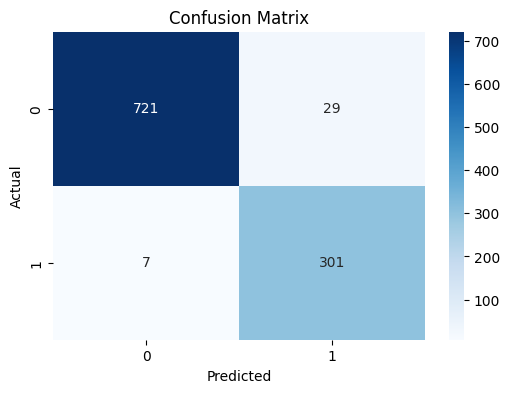

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

# Load Dataset
data = pd.read_csv('/content/frauds_dataset.csv')

# Encode categorical variables
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

# Feature Engineering
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

# Handle missing values
data.fillna(data.median(), inplace=True)

# Drop unnecessary columns
data.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}

# Define the Advanced Neural Network Model with L1_L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#classical supervised learning

Best Parameters: {'C': 100, 'solver': 'lbfgs'}
Accuracy: 0.9371
Precision: 0.8912
Recall: 0.8927
F1 Score: 0.8920


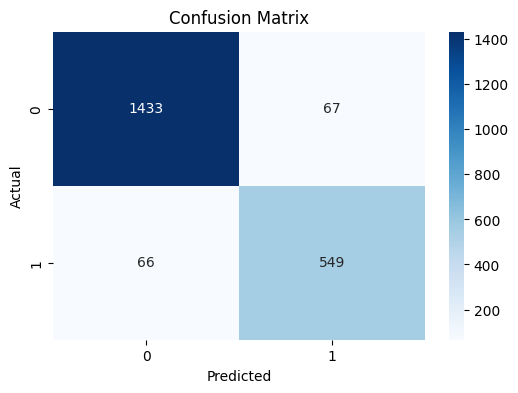

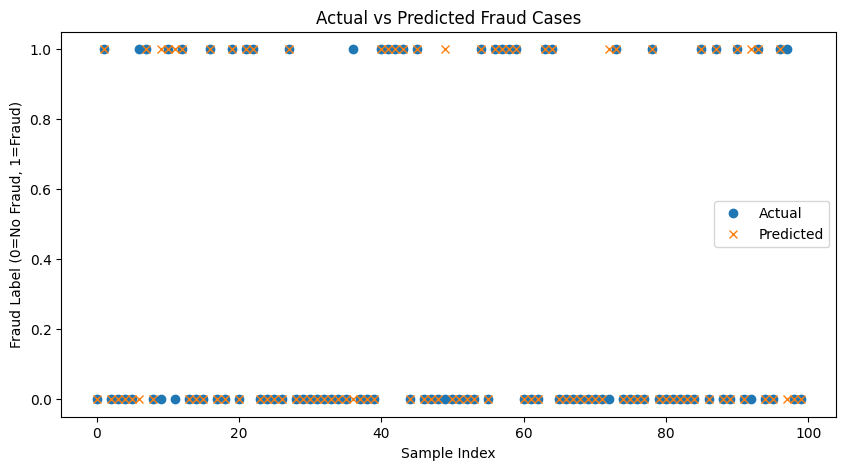

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = "/content/frauds_dataset.csv"
df = pd.read_csv(file_path)

# Encode categorical variables
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])
df['nameOrig'] = label_encoder.fit_transform(df['nameOrig'])
df['nameDest'] = label_encoder.fit_transform(df['nameDest'])

# Feature Engineering
df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['oldbalanceDest'] - df['newbalanceDest']
df['transaction_ratio_orig'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # Avoid division by zero
df['transaction_ratio_dest'] = df['amount'] / (df['oldbalanceDest'] + 1)

# Handle missing values
df.fillna(df.median(), inplace=True)

# Drop unnecessary columns
df.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = df.drop(columns=['isFraud'])
Y = df['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
selector = SelectKBest(f_classif, k=10)  # Keep 10 best features
X_selected = selector.fit_transform(X_scaled, Y)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.3, random_state=42, stratify=Y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, Y_train_resampled)
best_model = grid_search.best_estimator_

# Make predictions
Y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Print evaluation metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10,5))
plt.plot(Y_test.values[:100], label="Actual", marker='o', linestyle="")
plt.plot(Y_pred[:100], label="Predicted", marker='x', linestyle="")
plt.xlabel("Sample Index")
plt.ylabel("Fraud Label (0=No Fraud, 1=Fraud)")
plt.title("Actual vs Predicted Fraud Cases")
plt.legend()
plt.show()


In [ ]:
#A simple machine learning model based on neural networks

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7542 - loss: 0.5310 - val_accuracy: 0.8738 - val_loss: 0.3165
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9024 - loss: 0.2586 - val_accuracy: 0.9092 - val_loss: 0.2574
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9131 - loss: 0.2191 - val_accuracy: 0.9215 - val_loss: 0.1865
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9355 - loss: 0.1633 - val_accuracy: 0.9400 - val_loss: 0.1492
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9436 - loss: 0.1429 - val_accuracy: 0.9508 - val_loss: 0.1314
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9581 - loss: 0.1110 - val_accuracy: 0.9546 - val_loss: 0.1158
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9636 - loss: 0.0989 - val_accuracy: 0.9570 - val_loss: 0.1085
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9619 - loss: 0.1019 - val_accuracy: 0.9584 - val_

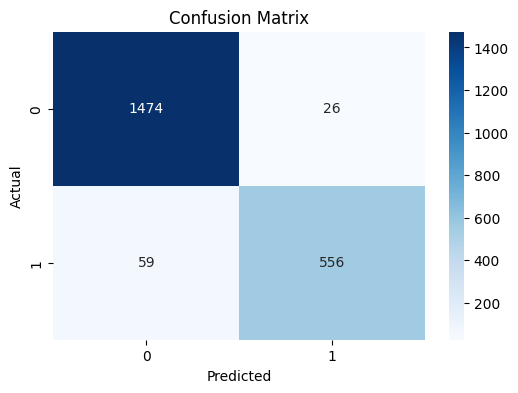

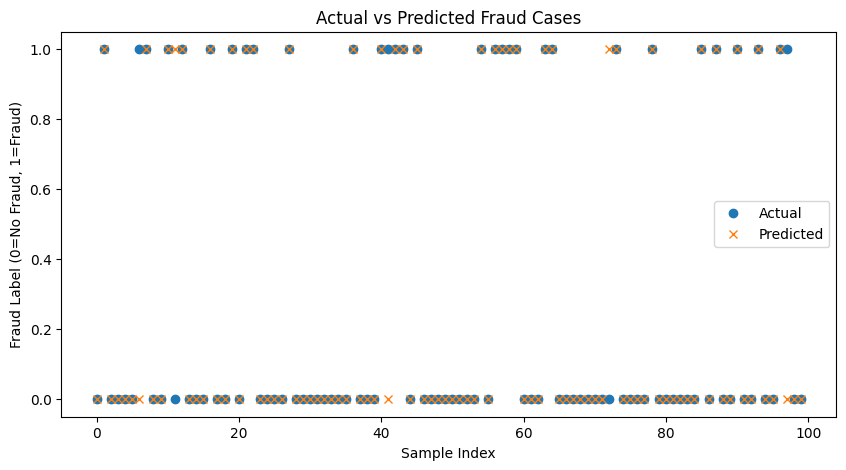

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the dataset
file_path = "/content/frauds_dataset.csv"
df = pd.read_csv(file_path)

# Encode categorical variables
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])
df['nameOrig'] = label_encoder.fit_transform(df['nameOrig'])
df['nameDest'] = label_encoder.fit_transform(df['nameDest'])

# Feature Engineering
df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['oldbalanceDest'] - df['newbalanceDest']
df['transaction_ratio_orig'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # Avoid division by zero
df['transaction_ratio_dest'] = df['amount'] / (df['oldbalanceDest'] + 1)

# Handle missing values
df.fillna(df.median(), inplace=True)

# Drop unnecessary columns
df.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = df.drop(columns=['isFraud'])
Y = df['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)

# Define a simple neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32, verbose=1)

# Make predictions
Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10,5))
plt.plot(Y_test.values[:100], label="Actual", marker='o', linestyle="")
plt.plot(Y_pred[:100], label="Predicted", marker='x', linestyle="")
plt.xlabel("Sample Index")
plt.ylabel("Fraud Label (0=No Fraud, 1=Fraud)")
plt.title("Actual vs Predicted Fraud Cases")
plt.legend()
plt.show()
